## RNN
##### Take more characters as input
##### We don't feed them all into single hidden layer as it squashes too much info too quickly
##### We make a deeper model that progressively fuses the information to make its guess about next characterin sequence
##### We arrive at something which looks like wavenet which predicts audio sequences instead of char/word sequences

In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['barjraj',
 'ramdin verma',
 'sharat chandran',
 'birender mandal',
 'amit',
 'kushal',
 'kasid',
 'shiv prakash']

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: ' ', 2: 'a', 3: 'b', 4: 'c', 5: 'd', 6: 'e', 7: 'f', 8: 'g', 9: 'h', 10: 'i', 11: 'j', 12: 'k', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 0: '.'}
28


In [7]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [8]:
block_size = 8 # context length

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([310156, 8]) torch.Size([310156])
torch.Size([38787, 8]) torch.Size([38787])
torch.Size([39068, 8]) torch.Size([39068])


In [9]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> e
.......e --> l
......el --> l
.....ell --> a
....ella --> k
...ellak --> a
..ellaka --> t
.ellakat --> e
ellakate --> .
........ --> j
.......j --> a
......ja --> x
.....jax --> .
........ --> p
.......p --> r
......pr --> a
.....pra --> m
....pram --> o
...pramo --> d
..pramod -->  


In [ ]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
  
  # -----------------------------------------------------------------------------------------------
class Embedding:
  def __init__(self,num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))
  
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]
  
  # -----------------------------------------------------------------------------------------------
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self,x):
    b,t,c = x.shape
    x = x.view(b,t//self.n,self.n*c)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

  # -----------------------------------------------------------------------------------------------
class Sequential:
  def __init__(self,layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return []

In [105]:
torch.manual_seed(42); # seed rng for reproducibility

In [106]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP

# C  = torch.randn((vocab_size, n_embd))
# layers = [
#     Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size),
# ]

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

#parameters = [C] + [p for layer in layers for p in layer.parameters()]
parameters = [p for layer in model.layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22476


In [97]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix],Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 2, 19, 10,  2,  3,  6, 13, 13],
        [ 0,  0,  0,  0,  0, 16, 14,  2],
        [ 0,  0,  0,  0,  0,  0,  0, 10],
        [ 0,  0,  0,  0,  0,  0, 12, 19]])

In [107]:
# for layer in model.layers:
#     print(layer.__class__.__name__,':', tuple(layer.out.shape))

In [82]:
# (torch.randn(4,80) @ torch.randn(80,200) + torch.randn(200)).shape

torch.Size([4, 200])

In [83]:
# (torch.randn(4,4,20) @ torch.randn(20,200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [ ]:
# e = torch.randn(4,8,10)

# a = e.view(4,-1,20)

In [108]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3270
  10000/ 200000: 2.2107
  20000/ 200000: 2.2844
  30000/ 200000: 2.4194
  40000/ 200000: 1.7673
  50000/ 200000: 2.0739
  60000/ 200000: 1.9773
  70000/ 200000: 1.9812
  80000/ 200000: 1.8505
  90000/ 200000: 2.0663
 100000/ 200000: 2.0667
 110000/ 200000: 1.9538
 120000/ 200000: 1.8535
 130000/ 200000: 1.9815
 140000/ 200000: 2.3167
 150000/ 200000: 1.8946
 160000/ 200000: 1.8815
 170000/ 200000: 1.5759
 180000/ 200000: 2.0102
 190000/ 200000: 1.7821


In [109]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
  layer.training = False

In [110]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.821645975112915
val 1.892126441001892


#### We observe that train and val loss are close to each other which indicates we are not overfitting and hence we can work with more complex networks or model to improve the performance

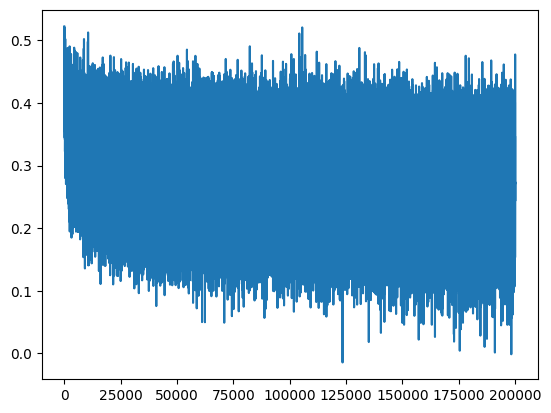

In [111]:
plt.plot(lossi)

##### plotting mean loss per 1000 iter

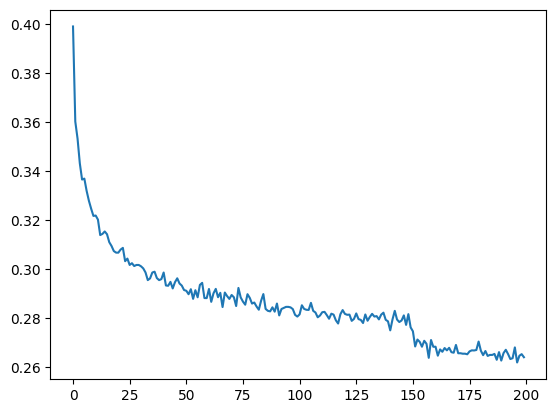

In [112]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [113]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      logits = model(torch.tensor([context])) # (1,block_size,d)
      probs = F.softmax(logits, dim=1)
      #ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

keldhire.
aver.
sheira.
sylana.
jozlynn.
abhishor mostelli.
kamley.
rohav parsh.
leana.
sacthea.
monu hatin.
kesen.
vijay.
ranni.
gaeden.
vivek.
arkin.
suraj.
brielima.
xyari.
